# Introduction

In this notebook, I will analyse the Seattle AirBNB Dataset from [Inside AirBnb](http://insideairbnb.com/). I will follow the CRISP-DM process when analysing their data. The CRISP-DM stages are:
- Business Understanding
- Data Understanding
- Data Preparation
- Modelling
- Evaluation
- Deployment

## Imports

In [179]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import altair as alt
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from multiprocessing import Pool
from multiprocessing_fn import distance_method
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import FunctionTransformer
import lightgbm as lgb
import _pickle as cPickle
import copy 

pd.set_option("display.max_columns",50)
alt.data_transformers.disable_max_rows()
%matplotlib inline

# Business and Data Understanding

I will answer the following 3 business questions:
1. Is there a significant difference between the returns of verified and non-verified host's listings in Seattle?
1. Is there a significant difference between the returns of super-Host Listings and Non-Superhost in Seattle?
1. Does close proximity to competition/ certain kinds of competition affect returns of surrounding AirBnB listings?
1. What factors strongly contribute to the price hosts set for their listings in Seattle?
1. Do communication verification methods chosen by host linked to their communication reviews?

In [2]:
data_dir = '../data'
raw_dir = data_dir + '/raw'
processed_dir = data_dir + '/processed'

reviews_df = pd.read_csv(raw_dir + '/reviews.csv')
calendar_df = pd.read_csv(raw_dir + '/calendar.csv')
listings_df = pd.read_csv(raw_dir + '/listings.csv')

reviews_df['date'] = pd.to_datetime(reviews_df['date'])
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
listings_df['last_scraped'] = pd.to_datetime(listings_df['last_scraped'])
listings_df['host_since'] = pd.to_datetime(listings_df['host_since'])

In [20]:
pp.ProfileReport(reviews_df).to_file(raw_dir + '/reviews_profile_report.html')

pp.ProfileReport(calendar_df).to_file(raw_dir + '/calendar_profile_report.html')

pp.ProfileReport(listings_df).to_file(raw_dir + '/listings_profile_report.html')

I used the Profile Reports from Pandas Profiling as well as this [data dictionary](../../data/raw/Inside%20Airbnb%20Data%20Dictionary.xlsx) from InsideAirBnB to understand the Data. The profile reports can be found here:
- [reviews_profile_report](../../data/raw/reviews_profile_report.html)
- [calendar_profile_report](../../data/raw/calendar_profile_report.html)
- [listings_profile_report](../../data/raw/listings_profile_report.html)

# Data Preparation

## Cleaning Dataset
 
 In this section, I fill nulls, drop unnecessary columns and correct datatypes

In [3]:
# Selecting the columes required for the analysis
listings_filtered_df = listings_df[['name', 'description', 'host_id','host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'latitude',
       'longitude', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',  'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']].copy()

In [4]:
listings_filtered_df[['host_has_profile_pic', 'host_is_superhost', 'host_identity_verified']] = listings_filtered_df[['host_has_profile_pic', 'host_is_superhost', 'host_identity_verified']].replace({'t':True, 'f':False})

In [5]:
# Filling Nulls
for col in ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'bedrooms', 'beds', 'bathrooms_text']:
    listings_filtered_df[col] = listings_filtered_df[col].fillna(listings_filtered_df[col].mode().iloc[0])
    
zero_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']    
listings_filtered_df[zero_cols] = listings_filtered_df[zero_cols].fillna(0)

listings_filtered_df['description'] = listings_filtered_df['description'].fillna('')

In [6]:
listings_filtered_df = listings_filtered_df.assign(host_response_rate=listings_filtered_df['host_response_rate'].replace('[\%]', '', regex=True).astype(int))
listings_filtered_df = listings_filtered_df.assign(host_acceptance_rate=listings_filtered_df['host_acceptance_rate'].replace('[\%]', '', regex=True).astype(int))
listings_filtered_df = listings_filtered_df.assign(bathrooms_text=listings_filtered_df['bathrooms_text'].replace('Half|half', '0.5', regex=True).replace('[\sA-Za-z\-]+', '', regex=True).astype(float))

listings_filtered_df = listings_filtered_df.assign(price=listings_filtered_df['price'].replace('[\$\,]', '', regex=True).astype(float))

## Derive Occupancy, Income per month and Nights per year 

In this section, I use the occupancy model described [here](http://insideairbnb.com/about.html#disclaimers)  or [here](http://insideairbnb.com/seattle/?neighbourhood=&filterEntireHomes=false&filterHighlyAvailable=false&filterRecentReviews=false&filterMultiListings=false#) to calculate the mentioned features. 

In [7]:
listings_filtered_df['estimated_bookings'] = listings_filtered_df.number_of_reviews_ltm * 2

listings_filtered_df['avg_length_of_stay'] = [min_nights if min_nights > 3 else 3 for min_nights in  listings_filtered_df['minimum_nights']]
uncapped_nights_per_year  = listings_filtered_df['estimated_bookings'] * listings_filtered_df['avg_length_of_stay']

# By limiting the nights to 255 in a year, we limit the occupancy to 70% as recommended by InsideAirBnB
listings_filtered_df['nights_per_year'] = [255 if nights > 255 else nights for nights in uncapped_nights_per_year]
listings_filtered_df['occupancy_rate'] = listings_filtered_df['nights_per_year']/365*100
listings_filtered_df['income_per_month']  = listings_filtered_df['nights_per_year']*listings_filtered_df['price']/12

## Extract Other Features

In [8]:
def item_list_counter(items_series):
    """
    This method takes a series that contains elements with list of strings and returns a dictionary that contains the total number of times each string in the lists 
    are mentioned in the entire series.
    
    :param series: Pandas Series object
    :return: dict 
    """
    items_list = items_series.apply(eval).tolist()
    counts_dict = {}
    for i, items in enumerate(items_list):
        for item in items:
            if counts_dict.get(item, None) is None:
                counts_dict[item] = 1
            else:
                counts_dict[item] += 1
    return counts_dict

### Host verification methods

In [9]:
%%time
verifications = listings_filtered_df.host_verifications.apply(eval).tolist()

# Selecting the Top Verification options
top_verification_options = ['email', 'phone', 'reviews', 'jumio', 'selfie', 'facebook', 'kba', 'work_email', 'google']  # 'identity_manual', 'offline_government_id', 'government_id', 

row_list = []
row = {}
for i, verif in enumerate(verifications):
    for item in top_verification_options:
        row[item] = int(item in verif)
    row_list.append(copy.deepcopy(row))
    
verifications_df = pd.DataFrame(row_list)
verifications_df.columns=['verif_'+col for col in top_verification_options]
verifications_df.sample(5)

Wall time: 124 ms


,verif_email,verif_phone,verif_reviews,verif_jumio,verif_selfie,verif_facebook,verif_kba,verif_work_email,verif_google
2438,1,1,0,0,0,0,0,0,0
1092,1,1,1,1,0,0,0,0,0
1506,1,1,1,1,1,0,0,0,0
2516,1,1,1,0,0,0,1,1,0
3816,0,1,1,0,1,0,0,0,0


### Grouping Amenities

In this section, I categorise the Amenities that are available in each listing

In [10]:
# Here we rank all amenities based on how often they are mentioned. We will use this to build categories for them
amenity_counter = item_list_counter(listings_filtered_df.amenities)
ammenity_counts_df = pd.DataFrame({'ammenity':amenity_counter.keys(), 'counts':amenity_counter.values()})
ammenity_counts_df.sort_values(by=['counts'], ascending=False).to_csv(processed_dir + "/ranking_of_ammenites.csv")

In [11]:
%%time
with open(processed_dir + '/ammenity_categories.txt') as fp:
    out = fp.read()

categories = []
categories
for string_ in out.split('\n'):
    if string_ == '':
        break
    categories.append(tuple(string_.split(':')))

amenities = listings_filtered_df.amenities.apply(eval).tolist()

row_list = []
row = {}
for amen in amenities:
    for item, categ_name in categories:
        row[categ_name] = pd.Series(amen).str.contains('(?i)'+item, regex=True).sum()
        
    row_list.append(copy.deepcopy(row))
    
amenities_df = pd.DataFrame(row_list)
amenities_df['TV'] = amenities_df['TV'] - amenities_df['TV_Entertainment']  # We separate TV with entertainment options from a TV set amenity
amenities_df.loc[amenities_df['TV'] < 0, 'TV'] = 0

amenities_df.columns=['amen_'+col for col in amenities_df.columns]
amenities_df.sample(5)

Wall time: 1min


,amen_TV,amen_TV_Entertainment,amen_Sound_System,amen_WorkSpace,amen_Internet,amen_Paid_Parking,amen_Free_Parking,amen_Clothing_Storage,amen_Linens,amen_House_Keeping,amen_Bathroom_Essentials,amen_Restuarant,amen_Breakfast,amen_Gym,amen_Pool_Sauna,amen_Games,amen_Children_Babies,amen_Dryer_Washer,amen_Backyard_Garden,amen_Beach_Water_Front,amen_Pets,amen_Kitchen,amen_Kitchen_Appliances,amen_Cooking_Dishes,amen_Host_Greeting,amen_Long_Term_Stay,amen_Indoor_Fireplace,amen_Outdoor,amen_Air_Conditioning,amen_Heating,amen_Safety_Security_First_Aid,amen_Staff
1766,1,0,0,0,1,0,1,1,2,1,2,0,1,0,0,0,0,4,1,0,0,1,5,2,0,1,0,3,1,1,3,0
4066,1,0,0,0,1,0,0,1,1,1,2,0,0,0,0,0,0,1,0,0,0,1,4,0,0,1,0,1,0,1,3,0
1788,1,0,0,1,1,0,2,1,2,1,3,0,0,0,0,0,3,4,1,0,0,0,5,2,0,1,0,2,3,1,7,0
874,1,0,0,0,1,0,2,0,0,1,1,0,0,0,0,0,0,4,0,0,0,1,1,0,0,0,0,0,0,1,2,0
877,0,2,0,1,1,0,1,1,2,1,3,0,1,0,0,0,1,4,0,0,0,1,8,4,0,1,0,0,0,1,4,0


### Proximity to Other Listings

In this section, I categorise the listings based on their proximity to other listings. The median distance between any 2 listings is about 5 km, so I choose categories below this value. i.e: below 500m, 500-1.5km and 1.5-4km

In [12]:
%%time
# Measuring Similarity
similar_locations_bool = [(listings_filtered_df[['property_type', 'bedrooms', 'beds']] == listings_filtered_df[['property_type', 'bedrooms', 'beds']].iloc[i]).sum(axis=1) >= 3 for i in range(listings_filtered_df.shape[0])]

Wall time: 14.6 s


In [13]:
index = listings_filtered_df.index.tolist()
lat_long_values = listings_filtered_df[['latitude','longitude']].values

list_of_lists = list(zip(list(lat_long_values), [lat_long_values]*len(lat_long_values), similar_locations_bool))

In [15]:
listings_filtered_df.bedrooms.unique(), listings_filtered_df.beds.unique()

(array([4., 1., 2., 3., 6., 5., 7., 8.]),
 array([ 4.,  1.,  2.,  3.,  5.,  0., 13.,  8.,  7.,  6., 14., 10., 15.,
         9., 16., 19., 12., 11.]))

In [16]:
%%time
pool = Pool(8)
distances_list = pool.map(distance_method, list_of_lists)
pool.close()

Wall time: 16min 58s


In [18]:
distances_df = pd.DataFrame(distances_list, columns=['dist_500m', 'dist_1500m', 'dist_4000m'])

In [19]:
distances_df.sample(5)

,dist_500m,dist_1500m,dist_4000m
586,5,15,46
2244,1,6,34
1287,1,1,12
2732,10,29,75
2048,2,7,16


In [29]:
alt.Chart(distances_df).mark_bar().encode(x=alt.X('dist_500m',bin=alt.Bin(step=1)), y='count()')

alt.Chart(...)

In [30]:
distances_df.dist_500m.quantile(0.5)

2.0

In [45]:
(distances_df.dist_500m > 4).sum()

1270

In [20]:
distances_df.to_csv(processed_dir + "/distances_df_new.csv", index=False)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

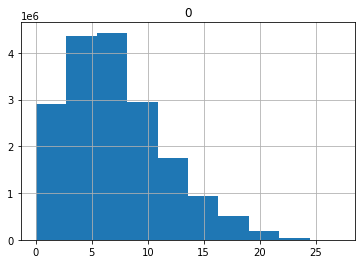

In [53]:
pd.DataFrame(full_list).hist()

In [62]:
temp = pd.DataFrame(full_list)
temp.shape

(18054001, 1)

In [66]:
temp[0].quantile(0.01), temp[0].quantile(0.1), temp[0].quantile(0.25), temp[0].quantile(0.4)

(0.45835667500423305,
 1.9847089954228732,
 3.7767634670609653,
 5.415159706303501)

### Other Features

In [35]:
listings_filtered_df['name_length'] = listings_filtered_df.name.apply(len)
# listings_filtered_df['host_verifications_no'] = listings_filtered_df.host_verifications.apply(lambda x: len(eval(x)))
# listings_filtered_df['amenities_no'] = listings_filtered_df.amenities.apply(lambda x: len(eval(x)))

## Merging all Features

In [36]:
listings_filtered_df = listings_filtered_df.drop(columns=['amenities', 'host_verifications', 'latitude', 'longitude', 'description', 'minimum_nights', 'number_of_reviews_ltm', 'host_id', 'host_listings_count', 'estimated_bookings', 'nights_per_year'])

In [37]:
listings_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4249 entries, 0 to 4248
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   name                                          4249 non-null   object 
 1   host_response_time                            4249 non-null   object 
 2   host_response_rate                            4249 non-null   int32  
 3   host_acceptance_rate                          4249 non-null   int32  
 4   host_is_superhost                             4249 non-null   bool   
 5   host_has_profile_pic                          4249 non-null   bool   
 6   host_identity_verified                        4249 non-null   bool   
 7   neighbourhood_group_cleansed                  4249 non-null   object 
 8   property_type                                 4249 non-null   object 
 9   room_type                                     4249 non-null   o

In [38]:
listings_merged_df = pd.concat([listings_filtered_df, verifications_df, amenities_df, distances_df], axis=1)

In [39]:
listings_merged_df.sample(5)

,name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,...,amen_Bathroom_Essentials,amen_Restuarant,amen_Breakfast,amen_Gym,amen_Pool_Sauna,amen_Games,amen_Children_Babies,amen_Dryer_Washer,amen_Backyard_Garden,amen_Beach_Water_Front,amen_Pets,amen_Kitchen,amen_Kitchen_Appliances,amen_Cooking_Dishes,amen_Host_Greeting,amen_Long_Term_Stay,amen_Indoor_Fireplace,amen_Outdoor,amen_Air_Conditioning,amen_Heating,amen_Safety_Security_First_Aid,amen_Staff,dist_500m,dist_1500m,dist_4000m
985,Beautiful French Style Home with Panoramic Views.,within a day,100,88,True,True,True,Queen Anne,Entire residential home,Entire home/apt,12,4.0,5.0,7.0,1200.0,0,0,0,0,4,0,5.00,5.00,5.00,5.00,...,1,0,1,0,1,0,0,3,0,0,0,1,0,0,0,1,1,0,1,1,3,0,1,1,6
1678,Quiet Relaxing Belltown Loft-Top Floor Unit - A/C,within an hour,100,97,True,True,True,Downtown,Entire loft,Entire home/apt,2,1.5,1.0,1.0,182.0,16,46,76,166,88,0,4.94,4.94,4.88,4.91,...,5,0,0,0,0,1,0,4,0,0,0,1,9,3,0,2,0,3,2,1,5,0,1,8,18
3820,"View. Capitol Hill, monthly rental!",within a few hours,90,82,False,True,True,Capitol Hill,Entire rental unit,Entire home/apt,4,1.0,1.0,1.0,129.0,5,28,58,333,0,0,0.00,0.00,0.00,0.00,...,1,0,0,0,0,0,0,3,0,0,0,1,0,0,0,1,0,0,1,1,2,0,27,138,342
2940,Capital Hill Oasis,within an hour,100,93,False,True,True,Capitol Hill,Entire condominium (condo),Entire home/apt,2,1.0,1.0,1.0,73.0,0,1,31,306,2,0,2.50,3.50,2.50,5.00,...,2,0,0,0,0,0,0,4,1,1,0,1,5,1,0,1,0,0,0,1,4,0,9,26,103
1845,Seaview Retreat in Seattle,within a few hours,100,90,True,True,True,Ballard,Entire guest suite,Entire home/apt,4,1.0,2.0,2.0,142.0,0,4,17,40,93,7,4.89,4.91,4.84,4.95,...,3,0,0,0,1,1,0,3,0,0,0,1,5,2,0,1,0,1,1,1,4,0,2,4,12


In [40]:
listings_merged_df.to_csv(processed_dir + '/listings_merged_df.csv', index=False)

In [192]:
%%time
# Evaluating cleaned dataset with Pandas Profiling
pp.ProfileReport(listings_merged_df,
    title="Cleaned Listings Report",
    correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": True},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": True},
        "cramers": {"calculate": False},
    },plot={
        "dpi": 1000, "image_format": "png"
    }, interactions={
        "targets":['income_per_month', 'dist_500m', 'occupancy_rate', 'review_scores_communication']
    }, missing_diagrams=None ,progress_bar=True).to_file(processed_dir + '/listings_merged_profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Wall time: 8min 14s


# Analysis and Modelling

In this section, I attempt to answer the 4 business questions using the cleaned data

In [594]:
def perform_permutation_test(group_1, group_2, permutations=10_000, confidence_interval=95):
    """
    This method performs a permutation test to determine if the mean difference between groups is due to random variation or if it's statistically significant
    :param group_1:
    :param group_2:
    :param permutations:
    :param confidence_interval:
    :return:
    """
    print("Our null hypothesis: The difference in mean values is due to random chance")
    group_1 = list(group_1)
    group_2 = list(group_2)
    mean_group_1= np.mean(group_1)
    mean_group_2= np.mean(group_2)
    test_statistic = mean_group_1 - mean_group_2
    print(f"Our test statistic is {test_statistic:,.4f}")
    
    full_set = group_1 + group_2
    proportions_group_1 = len(group_1)/len(full_set)
    print(f"Group 1 has a proportion of {proportions_group_1:.4f}")
    threshold = (1-proportions_group_1)
    
    # We perform the permutations
    mean_differences = []
    for i in range(permutations):
        # empty array to represent a random total sales w/ profile pic
        group_1_random = []
        # empty array to represent a random total sales w/o profile pic
        group_2_random = []

        # use a for loop to randomonly place the total sales in one of the two lists
        for item in full_set:
            random_value = np.random.random()
            # randomally assinging each value to a new list
            if random_value > threshold:
                group_1_random.append(item)
            elif random_value <= threshold:
                group_2_random.append(item)

        mean_group_1 = np.mean(group_1_random)
        mean_group_2 = np.mean(group_2_random)
        # find the itteration mean and append to our mean difference list
        iteration_mean_difference =  mean_group_1 - mean_group_2
        mean_differences.append(iteration_mean_difference)

    # We determine the P-Value
    total = 0
    for mean_diff in mean_differences:
        if mean_diff >= test_statistic:
            total += 1

    #p value calculated by calulating percentage of values greater then the mean difference
    p_value = total / permutations
    print(f"The p-value for these 2 groups is {p_value:.8f}")
    
    conf_interval = 1-confidence_interval/100
    if p_value > conf_interval :
        print(f"We fail to reject the Null Hypothesis")
    else:
        print(f"We reject the Null Hypothesis")
            
    return p_value, mean_differences

In [593]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    Your function should:
    1. Drop the rows with missing response values
    2. Drop columns with NaN for all the values
    3. Use create_dummy_df to dummy categorical columns
    4. Fill the mean of the column for any missing values 
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''
    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lgbm = lgb.LGBMRegressor(random_state=rand_state, n_estimators=100,
                         n_jobs=-1, verbose=1)\
    .fit(X_train, y_train, eval_set=[(X_test, y_test)],
         early_stopping_rounds=10,
         feature_name=list(df.drop(response_col, axis=1).columns),
         categorical_feature=cat_cols)

    #Predict using your model
    y_test_preds = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)
    y_train_preds = lgbm.predict(X_train, num_iteration=lgbm.best_iteration_)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lgbm, X_train, X_test, y_train, y_test

def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.feature_importances_
    coefs_df = coefs_df.sort_values('coefs', ascending=False)
    return coefs_df


## Is there a significant difference between the returns of verified and non-verified host's listings in Seattle?

In [595]:
%%time
output = perform_permutation_test(listings_merged_df[listings_merged_df.host_identity_verified==True].income_per_month , listings_merged_df[listings_merged_df.host_identity_verified==False].income_per_month)

Our null hypothesis: The difference in mean values is due to random chance
Our test statistic is 52.8465
Group 1 has a proportion of 0.8447
The p-value for these 2 groups is 0.21420000
We fail to reject the Null Hypothesis
Wall time: 17.8 s


In [596]:
%%time
output = perform_permutation_test(listings_merged_df[listings_merged_df.host_identity_verified==True].occupancy_rate , listings_merged_df[listings_merged_df.host_identity_verified==False].occupancy_rate)

Our null hypothesis: The difference in mean values is due to random chance
Our test statistic is 0.1024
Group 1 has a proportion of 0.8447
The p-value for these 2 groups is 0.46420000
We fail to reject the Null Hypothesis
Wall time: 18.3 s


There is no significant difference between the returns of Verified and Un-verified hosts in Seattle

## Is there a significant difference between the returns of super-Host Listings and Non-Superhost in Seattle?

In [597]:
%%time
output = perform_permutation_test(listings_merged_df[listings_merged_df.host_is_superhost==True].income_per_month , listings_merged_df[listings_merged_df.host_is_superhost==False].income_per_month)

Our null hypothesis: The difference in mean values is due to random chance
Our test statistic is 925.8078
Group 1 has a proportion of 0.4375
The p-value for these 2 groups is 0.00000000
We reject the Null Hypothesis
Wall time: 18.4 s


In [598]:
%%time
output = perform_permutation_test(listings_merged_df[listings_merged_df.host_is_superhost==True].occupancy_rate , listings_merged_df[listings_merged_df.host_is_superhost==False].occupancy_rate)

Our null hypothesis: The difference in mean values is due to random chance
Our test statistic is 21.1007
Group 1 has a proportion of 0.4375
The p-value for these 2 groups is 0.00000000
We reject the Null Hypothesis
Wall time: 18.9 s


There is no significant difference between the returns of Verified and Un-verified hosts in Seattle

## Does close proximity to competition/ certain kinds of competition affect returns of surrounding AirBnB listings?

Here, I define listings that have high competition around them as those with more than 57 listings within 500m of them. 57 is the 3rd Quantile of the histogram of 

In [599]:
listings_merged_df['Many_Competitors'] = None
listings_merged_df.loc[q2_df.dist_500m > 4, 'Many_Competitors'] = True
listings_merged_df.loc[listings_merged_df.Many_Competitors.isna(), 'Many_Competitors'] = False
listings_merged_df.Many_Competitors = listings_merged_df.Many_Competitors.astype(bool)

In [600]:
%%time
output = perform_permutation_test(listings_merged_df[listings_merged_df.Many_Competitors==False].income_per_month, listings_merged_df[listings_merged_df.Many_Competitors==True].income_per_month)

Our null hypothesis: The difference in mean values is due to random chance
Our test statistic is 380.2736
Group 1 has a proportion of 0.7011
The p-value for these 2 groups is 0.00000000
We reject the Null Hypothesis
Wall time: 17.8 s


It does matter. Proximity to many competitors does have an impact on the listings revenues

## What factors strongly contribute to the price hosts set for their listings in Seattle?

In [590]:
modelling_df = listings_merged_df.copy()

In [591]:
modelling_df.columns

Index(['name', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'accommodates', 'bathrooms_text',
       'bedrooms', 'beds', 'price', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'avg_length_of_stay', 'occupancy_rate', 'income_per_month',
       'name_length', 'verif_email', 'verif_phone', 'verif

In [592]:
modelling_df = modelling_df[['neighbourhood_group_cleansed',
       'property_type', 'room_type', 'accommodates', 'amen_TV_Entertainment',
       'amen_Sound_System', 'amen_WorkSpace', 'amen_Internet',
       'amen_Paid_Parking', 'amen_Free_Parking', 'amen_Clothing_Storage',
       'amen_Linens', 'amen_House_Keeping', 'amen_Bathroom_Essentials',
       'amen_Restuarant', 'amen_Breakfast', 'amen_Gym', 'amen_Pool_Sauna',
       'amen_Games', 'amen_Children_Babies', 'amen_Dryer_Washer',
       'amen_Backyard_Garden', 'amen_Beach_Water_Front', 'amen_Pets',
       'amen_Kitchen', 'amen_Kitchen_Appliances', 'amen_Cooking_Dishes',
       'amen_Host_Greeting', 'amen_Long_Term_Stay', 'amen_Indoor_Fireplace',
       'amen_Outdoor', 'amen_Air_Conditioning', 'amen_Heating',
       'amen_Safety_Security_First_Aid', 'amen_Staff', 'dist_500m', 'price']]

In [560]:
modelling_df.sample(5)

,neighbourhood_group_cleansed,property_type,room_type,accommodates,amen_TV_Entertainment,amen_Sound_System,amen_WorkSpace,amen_Internet,amen_Paid_Parking,amen_Free_Parking,amen_Clothing_Storage,amen_Linens,amen_House_Keeping,amen_Bathroom_Essentials,amen_Restuarant,amen_Breakfast,amen_Gym,amen_Pool_Sauna,amen_Games,amen_Children_Babies,amen_Dryer_Washer,amen_Backyard_Garden,amen_Beach_Water_Front,amen_Pets,amen_Kitchen,amen_Kitchen_Appliances,amen_Cooking_Dishes,amen_Host_Greeting,amen_Long_Term_Stay,amen_Indoor_Fireplace,amen_Outdoor,amen_Air_Conditioning,amen_Heating,amen_Safety_Security_First_Aid,amen_Staff,dist_500m,price
839,Capitol Hill,Entire guesthouse,Entire home/apt,2,0,0,1,1,0,2,1,0,1,2,0,0,0,0,0,0,3,0,0,0,0,3,1,0,1,0,0,0,1,5,0,1,83.0
2591,Capitol Hill,Entire rental unit,Entire home/apt,2,2,0,0,1,1,0,1,1,1,2,0,0,1,0,0,0,4,0,0,0,1,4,0,0,1,0,1,0,1,3,0,18,161.0
1356,Central Area,Entire townhouse,Entire home/apt,6,2,0,1,1,0,2,1,2,1,2,0,0,0,0,0,1,4,0,0,0,1,5,2,0,1,0,1,0,1,5,0,2,300.0
1200,Downtown,Entire residential home,Entire home/apt,6,2,0,1,1,0,1,0,1,1,2,0,0,1,2,0,0,4,1,0,0,1,5,1,0,1,0,1,1,1,3,0,1,246.0
2955,Downtown,Entire rental unit,Entire home/apt,2,0,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,3,0,0,0,1,0,0,0,1,0,0,0,1,1,0,48,354.0


In [563]:
cat_cols_lst = list(modelling_df.select_dtypes(include=['object']).columns)

mapped_dict = {}
for col in cat_cols_lst:
    mapped_dict[col] = LabelEncoder().fit(modelling_df[col])
    modelling_df[col] = mapped_dict[col].transform(modelling_df[col])

transformer = FunctionTransformer(np.log1p)
modelling_df.price = transformer.fit_transform(modelling_df.price)
modelling_df.price.hist()

In [568]:
%%time
#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(modelling_df, 'price', cat_cols_lst, dummy_na=False, rand_state=42)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 2974, number of used features: 35
[LightGBM] [Info] Start training from score 4.900312
[1]	valid_0's l2: 0.349155
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.311274
[3]	valid_0's l2: 0.280971
[4]	valid_0's l2: 0.256103
[5]	valid_0's l2: 0.235761
[6]	valid_0's l2: 0.218342
[7]	valid_0's l2: 0.203617
[8]	valid_0's l2: 0.191808
[9]	valid_0's l2: 0.182227
[10]	valid_0's l2: 0.174785
[11]	valid_0's l2: 0.168324
[12]	valid_0's l2: 0.162802
[13]	valid_0's l2: 0.158341
[14]	valid_0's l2: 0.154767
[15]	valid_0's l2: 0.151672
[16]	valid_0's l2: 0.14918
[17]	valid_0's l2: 0.147191
[18]	valid_0's l2: 0.14564
[19]	valid_0's l2: 0.144259
[20]	valid_

E:\ProgramData\Miniconda3\envs\project_1_udacity\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
E:\ProgramData\Miniconda3\envs\project_1_udacity\lib\site-packages\lightgbm\basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['neighbourhood_group_cleansed', 'property_type', 'room_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
E:\ProgramData\Miniconda3\envs\project_1_udacity\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
E:\ProgramData\Miniconda3\envs\project_1_udacity\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [578]:
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.7788549933253837.  The rsquared on the test data was 0.6631475265528586.


In [585]:
#Use the function
coef_df = coef_weights(lm_model, X_train)
coef_df.head()

,est_int,coefs
3,accommodates,183
0,neighbourhood_group_cleansed,172
35,dist_500m,147
25,amen_Kitchen_Appliances,98
1,property_type,97


In [588]:
alt.Chart(coef_df).mark_bar().encode(x=alt.X('coefs:Q'), y=alt.Y('est_int:N', sort='-x'))

alt.Chart(...)